Processing video: C:\Users\olgan\Desktop\Python-Video Analysis\mp4\Boruto vs Code Boruto_ Naruto Next Generations.mp4
Number of frames: 4208
FPS: 23.976023976023978
This video may contain potential epilepsy triggers.
the frames [2768, 2769, 3379, 3381, 3968] in this video may trigger Epilepsy 
This video sound is safe for kids. as the max decibel level is -9.235523223876953
This video contains 0.8109225630760193 audio percentage.
Processing video: C:\Users\olgan\Desktop\Python-Video Analysis\mp4\Boruto's Sacrifice Boruto_ Naruto Next Generations.mp4
Number of frames: 3987
FPS: 23.976023976023978
This video may contain potential epilepsy triggers.
the frames [3747] in this video may trigger Epilepsy 
This video sound is safe for kids. as the max decibel level is -10.875134468078613
This video contains 0.8182849287986755 audio percentage.
Processing video: C:\Users\olgan\Desktop\Python-Video Analysis\mp4\Farewell Naruto Boruto_ Naruto Next Generations.mp4
Number of frames: 4516
FPS: 23.9

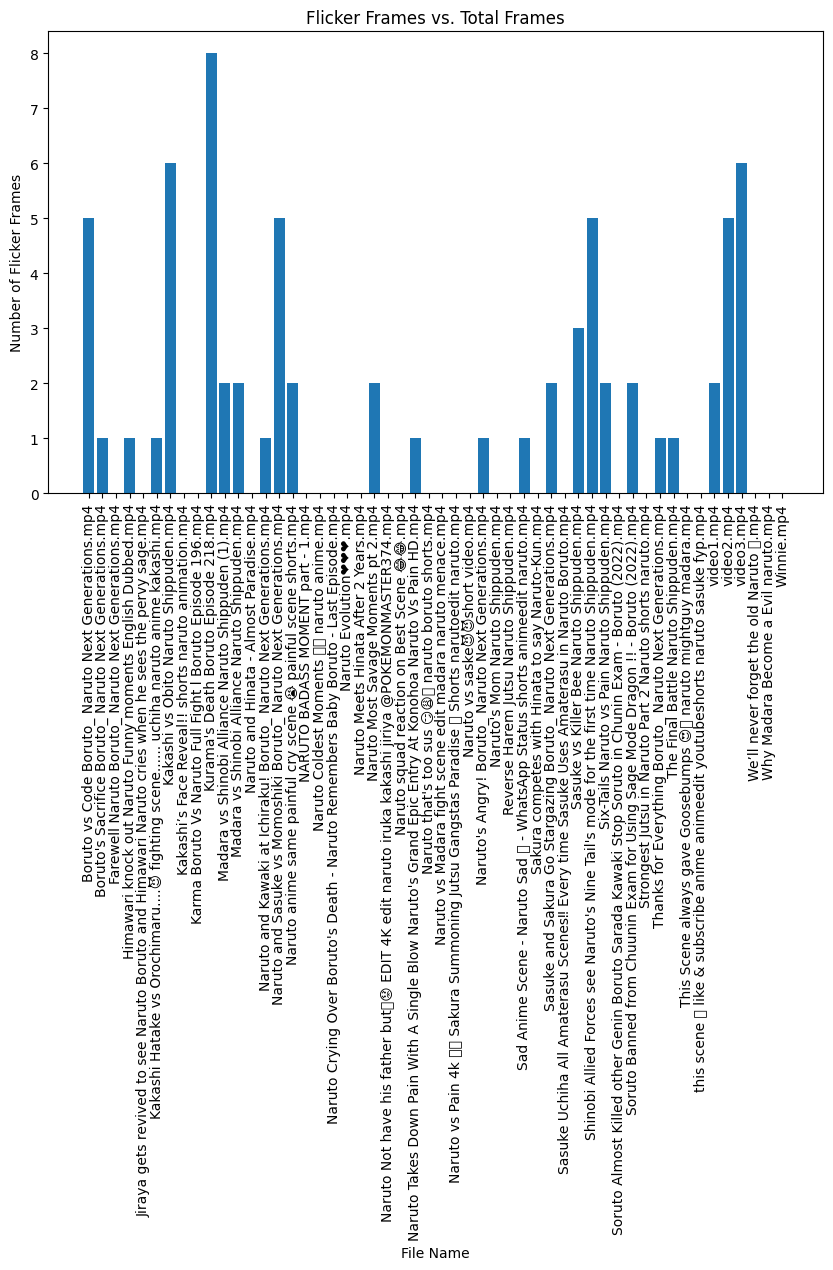

Therefore the Series Degree of Appropriateness is :  0.0 % and Not suitable for children


In [1]:
import cv2
import os
import subprocess
from glob import glob
import librosa
import numpy as np
from cv2 import imwrite
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

video_directory = r'C:\Users\olgan\Desktop\Python-Video Analysis\mp4'

# Retrieve a list of the videos stored in the directory above
video_files = glob(os.path.join(video_directory, '*.mp4'))

# Initialize a counter for suitable videos
suitable_videos = 0

flicker_frames_list = [] 
total_frames_list = [] 

# Iterate over each video file
for video_file in video_files:
   
    print(f"Processing video: {video_file}")

    # Open the video file
    cap = cv2.VideoCapture(video_file)


    n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) # total frame s of each video (number)
    fps = cap.get(cv2.CAP_PROP_FPS) # get the FPS
    total_frames_list.append(n_frames) # Store the total number of frames in the list 


    print(f"Number of frames: {n_frames}")
    print(f"FPS: {fps}")

    # Initialize variables for analysis
    luminance_threshold = 130  # fixed threshold we defined through references studying
    flicker_threshold = 1  # Set flickering frames threshold to consider a video safe
    flicker_frames = [] # list used to store the flickering frames


    # Perform the desired actions on each frame
    ret, prev_img = cap.read()  # Read the first frame
    frame_count = 0
    while True:
        ret, img = cap.read()
        if not ret:
            break

        # Convert the previous and the current frame to grayscale
        gray_prev = cv2.cvtColor(prev_img, cv2.COLOR_BGR2GRAY)
        gray_current = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


        # Calculate the absolute difference between the grayscale representations of the previous and current frames
        diff = cv2.absdiff(gray_prev,gray_current)

        # Calculate the average difference of the frame to measure the overall change in luminance
        average_difference = np.mean(diff)

        # Check if the average difference exceeds the luminance threshold, which indicates potential flickering
        if average_difference > luminance_threshold:
            flicker_frames.append(frame_count)
            if frame_count < n_frames:   # Check if the frame count is within the valid range 
                height = 350/max(prev_img.shape[0], img.shape[0])
                frame1 = cv2.resize(prev_img, (int(prev_img.shape[1] * height),int(prev_img.shape[0]*height)))# resize the frames to have the same height while maintaining the aspect ratio
                frame2 = cv2.resize(img, (int(img.shape[1]  * height),int(img.shape[0]*height)))

                # Combine the resized frames horizontally in order to perform a side by side comparison
                combined_frames = np.concatenate((frame1, frame2), axis=1)

                #Display the combined frames to visually observe the potential flickering
                cv2.imshow("Frames", combined_frames)
                cv2.waitKey(0)
                cv2.destroyAllWindows()

        # Update the previous frame to be the current frame, ready for the next iteration
        prev_img = img

        frame_count += 1 # increase the frame count by 1

    # Release the video capture object (this happens to free resources)
    cap.release()
    cv2.destroyAllWindows()

    # using FFmpeg to convert the video to audio so as to perform the audio analysis
    audio_file = video_file.replace('.mp4', '.wav')
    subprocess.run(['ffmpeg', '-i', video_file, '-vn', '-acodec', 'pcm_s16le', '-ar', '0', '-ac', '2', audio_file])

    # Perform audio analysis 
    audio, sr = librosa.load(audio_file, sr=None)  # Load audio with original sampling rate

    # Calculate the decibel levels of the loaeded audio, the average decibel, and the maximum
    decibel_levels = librosa.amplitude_to_db(np.abs(audio))
    average_decibel = np.mean(decibel_levels)
    max_decibel = np.max(decibel_levels)

    # Perform high-frequency analysis
    fmax = 300  
    spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, fmax=fmax)

    # Calculate the presence of high-frequency content in the spectrogram
    high_freq_presence = np.sum(spectrogram[20:, :]) / np.sum(spectrogram)

 #Analysis based on our thresholds to evaluate the suitability

    # Perform Photosensitive Epilepsy Analysis
    if len(flicker_frames) >= flicker_threshold:
        print("This video may contain potential epilepsy triggers.")
        print(f"the frames {flicker_frames} in this video may trigger Epilepsy ")



    # Evaluate the suitability of audio for kids
    if max_decibel > 90 or average_decibel > 50:   #
        print("This video may have loud or intense audio that may not be safe for kids.")
    else:
        print(f"This video sound is safe for kids. as the max decibel level is {max_decibel}")

    # Evaluate the presence of high-frequency components
    if high_freq_presence > 0.2:
        print(f"This video contains {high_freq_presence} audio percentage.")
    else:
        print(f"This video does not have significant {high_freq_presence}  audio percentage.")

    
    os.remove(audio_file)

    
    if len(flicker_frames) < flicker_threshold and max_decibel <= 90 and average_decibel <= 50 and high_freq_presence <= 0.2:
        suitable_videos += 1  # Increment suitable_videos count

    flicker_frames_list.append(len(flicker_frames))

plt.figure(figsize=(10, 6))
plt.bar(range(len(video_files)), flicker_frames_list, tick_label=[os.path.basename(file) for file in video_files])
plt.xlabel('File Name')
plt.ylabel('Number of Flicker Frames')
plt.title('Flicker Frames vs. Total Frames')
plt.xticks(rotation=90)
plt.tight_layout()
print("The Flicker Frames of the videos tested compared to the total frames of the videos are shown below")

plt.show()

# We set the percentage_suitable to be the quotient  of the amount of suitable_videos divided by thu number of all videos multiplied by 100
percentage_suitable = (suitable_videos / len(video_files)) * 100


# Determine the degree of appropriateness based on the percentage of suitable videos (fixed by us)
if percentage_suitable == 100:
    degree_of_appropriateness = "Suitable for all children"
elif 80 <= percentage_suitable < 100:
    degree_of_appropriateness = "Suitable for children over 6 years old"
elif 60 <= percentage_suitable < 80:
    degree_of_appropriateness = "Suitable for children over 10 years old"
elif 40 <= percentage_suitable < 60:
    degree_of_appropriateness = "Suitable for children over 12 years old"
elif 20 <= percentage_suitable < 40:
    degree_of_appropriateness = "Suitable for children over 15 years old"
else:
    degree_of_appropriateness = "Not suitable for children"


print(f"Therefore the Series Degree of Appropriateness is :  {percentage_suitable} % and {degree_of_appropriateness}")